In [21]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns
import spacy
import transformers
import torch

from datasets import Dataset
from hdbscan import HDBSCAN
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM
)
from umap import UMAP
from wordcloud import WordCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Read data

In [2]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_data.json')
test_data_path = os.path.join(data_dir, 'test_data.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'caption': [], 'label': []}
    for value in data.values():
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
train_df['str_label'] = train_df['label'].replace(id2label)
test_df = generate_df_from_json(test_data_path)
test_df['str_label'] = test_df['label'].replace(id2label)

#train_data = Dataset.from_pandas(train_df).train_test_split(test_size=0.15, seed=4999)
#test_data = Dataset.from_pandas(train_df)
#print(train_data)

## Generate embeddings

In [3]:
embedding_model = SentenceTransformer("all-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("paraphrase-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to('cuda')

def generate_embeddings(df: pd.DataFrame, text_col: str):
    sentences = df[text_col].tolist()
    embeddings = embedding_model.encode(sentences)

    return embeddings
    
train_embeddings = generate_embeddings(train_df, 'caption')
test_embeddings = generate_embeddings(test_df, 'caption')

## Dimensionality reduction (UMAP)

We are going to reduce dimensonality:
1. For documents visualization, with 2 dimensions
2. For documents clustering, with more dimensions

### For documents visualization

In [15]:
viz_reducer = UMAP(n_neighbors=15, n_components=2, metric='cosine')
viz_train_reduced = viz_reducer.fit_transform(train_embeddings)

<Axes: xlabel='x', ylabel='y'>

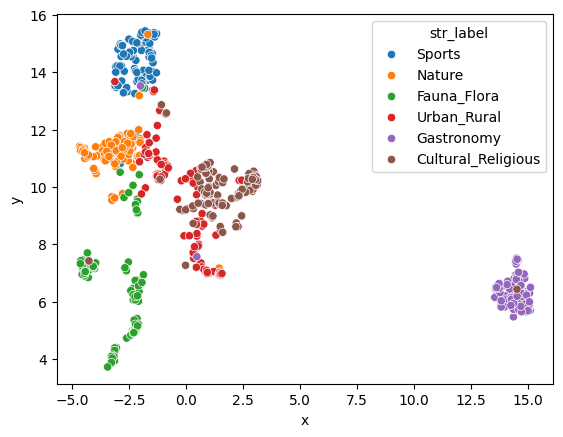

In [16]:
train_df['x'] = viz_train_reduced[:, 0]
train_df['y'] = viz_train_reduced[:, 1]
sns.scatterplot(
    train_df, x='x', y='y', hue='Labels', 
    palette=sns.color_palette("tab10", n_colors=6)
)

### For clustering

In [17]:
reducer = UMAP(n_neighbors=15, n_components=20, metric='cosine')
train_reduced = reducer.fit_transform(train_embeddings)

## Clustering

### HDBSCAN

In [19]:
clusterer = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
clusterer.fit(train_reduced)

HDBSCAN(min_cluster_size=20, prediction_data=True)

/tmp/ipykernel_23243/369388367.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(


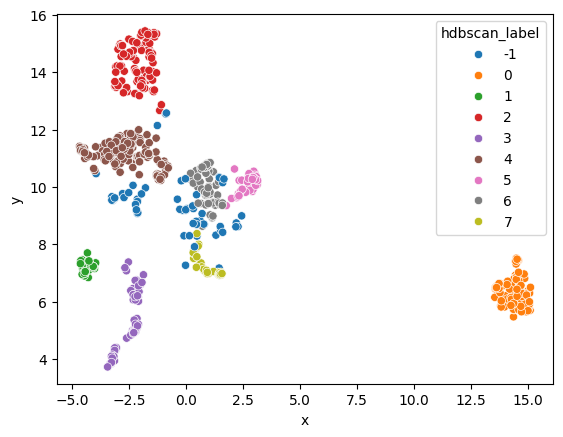

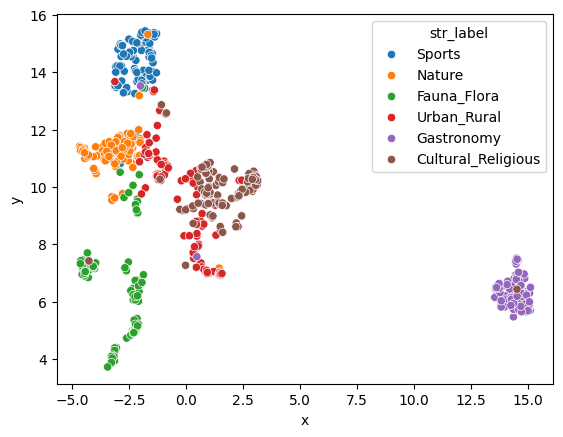

In [20]:
train_df['hdbscan_label'] = clusterer.labels_
sns.scatterplot(
    train_df, x='x', y='y', hue='hdbscan_label', 
    palette=sns.color_palette("tab10", n_colors=10)
)
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='str_label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

<Axes: ylabel='$\\lambda$ value'>

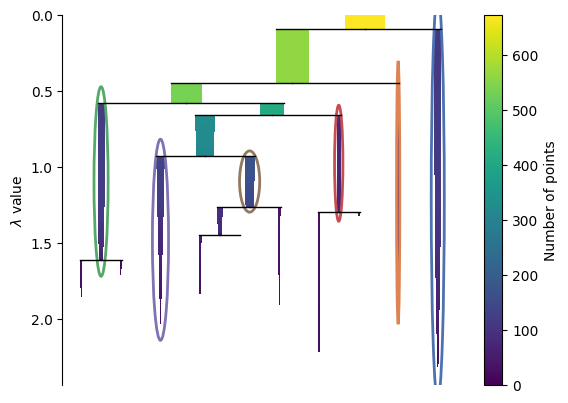

In [27]:
clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 8)
)

### KMeans

In [22]:
kmeans_clusterer = AgglomerativeClustering(n_clusters=6)#, n_init=20, max_iter=10000)
kmeans_clusterer.fit(train_reduced)

AgglomerativeClustering(n_clusters=6)

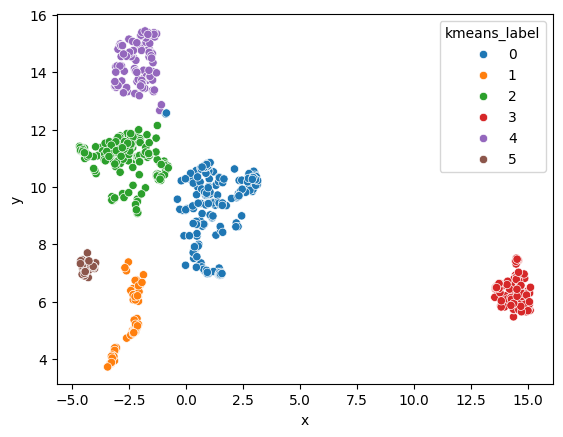

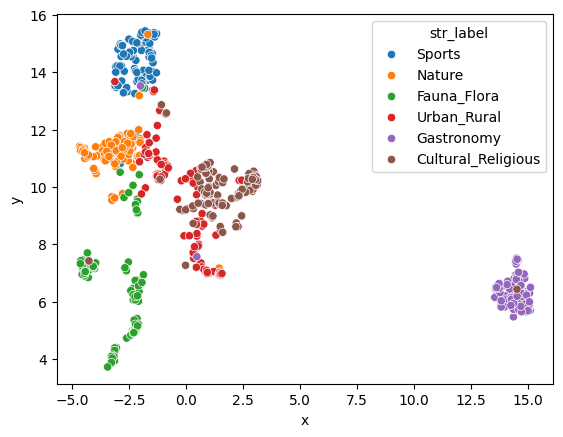

In [23]:
train_df['kmeans_label'] = kmeans_clusterer.labels_
sns.scatterplot(
    train_df, x='x', y='y', hue='kmeans_label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='str_label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

## Clusters BoW

In [26]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.7)

# Get distinct clusters labels
distinct_clusters = train_df['kmeans_label'].unique()


In [25]:
representative_words = {}
for c in distinct_clusters:
    df = train_df[train_df['cluster_label'] == c]
    # Fit and transform the documents
    tfidf_matrix = vectorizer.fit_transform(df['caption'])
    
    # Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Sum the TF-IDF scores for each word across all documents
    tfidf_sum = tfidf_df.sum(axis=0)

    # Create a dictionary of words and their corresponding TF-IDF scores
    word_tfidf_dict = tfidf_sum.to_dict()
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_tfidf_dict)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    representative_words[c] = tfidf_sum.sort_values(ascending=False).head(20).index.to_list()
    
print(representative_words)

NameError: name 'distinct_clusters' is not defined

## Zero-shot cluster classification

In [37]:
llama_model_id = 'meta-llama/Llama-2-7b-hf'
labels = ['Sports', 'Nature', 'Urban and rural', 'Flora and fauna', 'Gastronomy', 'Cultural and religious']

def generate_prompt(words, labels):
    prompt = f"""The following words are the more representative within a cluster. \
Given these words, classify the cluster into one of the categories: \
{', '.join(labels)}\n\nWords: {', '.join(words)}"""
    return prompt

def classify_text(model, tokenizer, words, labels, max_length=100):
    prompt = generate_prompt(words, labels)
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(inputs["input_ids"], max_length=max_length)

    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the category from the generated text
    category = generated_text.split("Category:")[-1].strip().split('\n')[0]
    return category

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(llama_model_id)
model = AutoModelForCausalLM.from_pretrained(llama_model_id)
for cluster, words in representative_words.items():
    category = classify_text(model, tokenizer, words, labels)
    print(words, category)

    

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

: 